In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    !pip3 install pickle5 -q
    !apt-get install p7zip-full -q
    #!7z x 'drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z'
    #!7z x 'drive/MyDrive/Colab Notebooks/Project/RHD_published_v2.zip'
    !cp 'drive/MyDrive/Colab Notebooks/Project/Networks.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/HandDataset_noCoords.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/Rotations.py' .
    PATH = 'drive/MyDrive/Colab Notebooks/Project/'
except:
    IN_COLAB = False
    PATH = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists...
Building dependency tree...
Reading state information...
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
if IN_COLAB:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

Tue Dec  7 06:01:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import reload

from HandDataset_noCoords import *
from Networks import *

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [24]:
batch_size = 128
img_size = 64
nc, nz = 3, 128 # number of channels in training images
ngf, ndf = 64, 64
num_epochs = 40
lr, beta1 = 0.0001, 0.5 # hyperparam for Adam optimizers
lambda_mse = 6e-3

In [25]:
synth_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

real_transform = transforms.Compose([
    transforms.CenterCrop(112),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5),(.5)) # (replace with actual mean and std)
])

synth_ds = HandDataset(
    img_dir='RHD_published_v2/training/color',
    mask_dir='RHD_published_v2/training/mask',
    anno_path='RHD_published_v2/training/anno_training.pickle',
    black_size=320,
    zfill=5,
    ext='.png',
    transform=synth_transform,
    masked=True,
    centered=True,
    coef = 2.2,
    normalise=True
)

real_ds = HandDataset(
    img_dir='FreiHAND_split/training/rgb',
    mask_dir='FreiHAND_split/training/mask',
    anno_path='FreiHAND_split/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=False
)

In [26]:
synth_loader = DataLoader(synth_ds, batch_size=batch_size, shuffle=True, drop_last=True)
real_loader = DataLoader(real_ds, batch_size=batch_size, shuffle=True, drop_last=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
Enc = Encoder(nz=nz, nf=ngf).to(device)
Enc.load_state_dict(torch.load(PATH+'models/vae/Enc_epoch_21.pth'))
Enc.eval()

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (fc): Linear(in_features=16384, out_features=1024, bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (activ): LeakyReLU(negative_slope=0.2)
  (mu): Linear(in_features=1024, out_features=128, bias=True)
  (logVar): Linear(in_features=1024, out_features=128, bias=True)
)

In [28]:
Dec = Decoder(nz=nz, nf=ndf).to(device)
Dec.load_state_dict(torch.load(PATH+'models/vae/Dec_epoch_21.pth'))
Dec.eval()

Decoder(
  (fc): Linear(in_features=128, out_features=16384, bias=False)
  (conv1): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm1d(16384, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (activ): LeakyReLU(negative_slope=0.2)
)

In [29]:
D = Discriminator(ndf=ndf).to(device)
D.load_state_dict(torch.load(PATH+'models/gan/D_27_11_21_epoch_30.pth'))
D.eval()

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=8192, out_features=512, bias=False)
  (FC2): Linear(in_features=512, out_features=66, bias=True)
  (activ): LeakyReLU(negative_slope=0.2)
)

In [30]:
optimizerEnc = optim.Adam(Enc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerDec = optim.Adam(Dec.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerDis = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_real = next(iter(real_loader))[0][:64].to(device)
fixed_synth = next(iter(synth_loader))[0][:64].to(device)

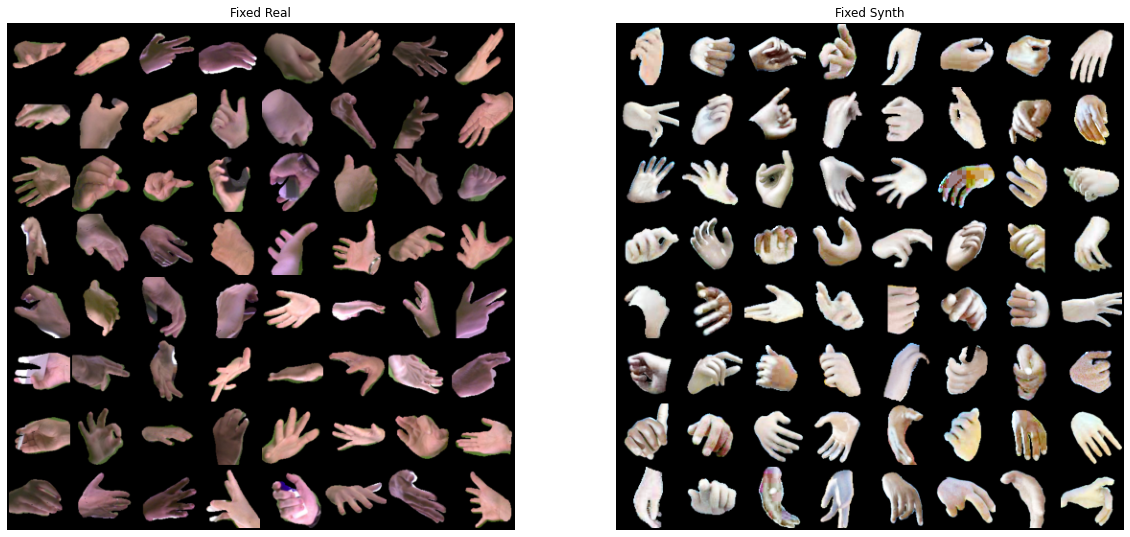

In [31]:
plt.figure(figsize=(20,40))
ax = plt.subplot(2,2,1)
plt.axis('off')
plt.title('Fixed Real')
plt.imshow(np.transpose(vutils.make_grid(fixed_real[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

ax = plt.subplot(2,2,2)
plt.axis('off')
plt.title('Fixed Synth')
plt.imshow(np.transpose(vutils.make_grid(fixed_synth[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

In [32]:
# Lists to keep track of progress
img_list_real = []
img_list_fake = []
Enc_losses = []
Dec_losses = []
D_losses = []

iters = 0
epoch = 0
gamma = 0.1

In [33]:
print("Starting Training Loop...")

while epoch < num_epochs:
    ##########################################
    # (0) Set up iterations of both loaders  #
    ##########################################
    synth_loader_iterator = iter(synth_loader)
    for i, real_batch in enumerate(real_loader):
        try:
           synth_batch = next(synth_loader_iterator)
        except StopIteration:
           synth_loader_iterator = iter(synth_loader)
           synth_batch = next(synth_loader_iterator)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        #### Train with all-real batch ####
        D.zero_grad() # zero all accumulated gradients of discriminator;
        Enc.zero_grad()
        Enc.requires_grad_ = False
        Dec.zero_grad()

        real_batch_normalised = real_batch[0] * 0.5 + 0.5 # un-transforms.normalise
        real_batch_normalised = NormaliseBatch(real_batch_normalised)

        ### TRAIN DISCRIMINATOR ###
        imgs = real_batch[0].to(device) # load real images to device;
        imgs_norm = real_batch_normalised.to(device)
        #xyz = real_batch[1].view(batch_size,22*3).type(torch.float).to(device)

        mu, logVar = Enc(imgs_norm) # encode images into distribution
        z = reparameterize(mu, logVar) # sample z from distribution
        x_hat = Dec(z)
        Zp = torch.randn(batch_size, nz).to(device) # samples from standard normal
        Xp = Dec(Zp)

        disc_class_original,_,disc_layer_original = D(imgs, mode='XYZ')
        disc_class_original = disc_class_original.squeeze()
        disc_layer_original = disc_layer_original.squeeze()
        bce_dis_original = F.binary_cross_entropy(disc_class_original, torch.ones(imgs.shape[0]).to(device), reduction='sum')
        #mse_xyz_original = F.mse_loss(disc_xyz_original, xyz, reduction='sum')

        disc_class_predicted,_,disc_layer_predicted = D(x_hat.detach(), mode='XYZ')
        disc_class_predicted = disc_class_predicted.squeeze()
        disc_layer_predicted = disc_layer_predicted.squeeze()
        bce_dis_predicted = F.binary_cross_entropy(disc_class_predicted, torch.zeros(imgs.shape[0]).to(device), reduction='sum')
        #mse_xyz_predicted = F.mse_loss(disc_xyz_predicted, xyz, reduction='sum')

        disc_class_sampled,_,_ = D(Xp.detach())
        disc_class_sampled = disc_class_sampled.squeeze()
        bce_dis_sampled = F.binary_cross_entropy(disc_class_sampled, torch.zeros(Zp.shape[0]).to(device), reduction='sum')

        #mse_xyz = mse_xyz_original + mse_xyz_predicted
        L_dis = bce_dis_original + bce_dis_predicted + bce_dis_sampled# + gamma*mse_xyz
        L_dis.backward()
        optimizerDis.step()

        ### TRAIN VAE ###
        Enc.zero_grad()
        Dec.zero_grad() 
        D.zero_grad()

        disc_class_original,_,disc_layer_original = D(imgs, mode='XYZ')
        #disc_class_original = disc_class_original.squeeze()
        disc_layer_original = disc_layer_original.squeeze()
        #bce_dis_original = F.binary_cross_entropy(disc_class_original, torch.ones(imgs.shape[0]).to(device), reduction='sum')
        #mse_xyz_original = F.mse_loss(disc_xyz_original, xyz, reduction='sum')

        disc_class_predicted,_,disc_layer_predicted = D(x_hat, mode='XYZ')
        disc_class_predicted = disc_class_predicted.squeeze()
        disc_layer_predicted = disc_layer_predicted.squeeze()
        bce_dis_predicted = F.binary_cross_entropy(disc_class_predicted, torch.ones(imgs.shape[0]).to(device), reduction='sum')
        #mse_xyz_predicted = F.mse_loss(disc_xyz_predicted, xyz, reduction='sum')

        disc_class_sampled,_,_ = D(Xp.detach())
        disc_class_sampled = disc_class_sampled.squeeze()
        bce_dis_sampled = F.binary_cross_entropy(disc_class_sampled, torch.ones(Zp.shape[0]).to(device), reduction='sum')

        #mse_xyz = mse_xyz_original + mse_xyz_predicted
        L_dis = bce_dis_predicted + bce_dis_sampled
        mse = F.mse_loss(disc_layer_original, disc_layer_predicted, reduction='sum')
        kl = 0.5 * torch.sum(-1 -logVar + mu.pow(2) + logVar.exp()) #DKL

        L_dec = lambda_mse*mse + L_dis# + gamma*mse_xyz
        L_dec.backward()#retain_graph=True)
        #L_dec.requires_grad_ = False

        #Enc.zero_grad()
        #L_enc = kl + mse + gamma*2*mse_xyz
        #L_enc.backward()

        #L_dec.requires_grad_ = True

        #optimizerEnc.step()
        optimizerDec.step()

        #Output training stats
        if i % 50 == 0:
            print('[%d][%d/%d]\tLoss_Enc: NA\tLoss_Dec: %.3f\tLoss_Dis: %.3f'
                  % (epoch, i, len(real_loader),
                    L_dec.item(), L_dis.item()))

        # Save Losses for plotting later
        #Enc_losses.append(L_enc.item())
        Dec_losses.append(L_dec.item())
        D_losses.append(L_dis.item())

        if iters % 500 == 0:
            torch.save(Enc.state_dict(), PATH+'models/vaegan/enc_checkpoint_epoch_{}.pth'.format(epoch))
            torch.save(Dec.state_dict(), PATH+'models/vaegan/dec_checkpoint_epoch_{}.pth'.format(epoch))
            torch.save(D.state_dict(), PATH+'models/vaegan/D_checkpoint_epoch_{}.pth'.format(epoch))

            with torch.no_grad():
                plt.figure(figsize=(15,30))

                mu,logVar = Enc(fixed_real)
                z = reparameterize(mu,logVar)
                x = Dec(z).detach().cpu()
                img_list_real.append(vutils.make_grid(x, padding=2, normalize=True))
                ax = plt.subplot(2,2,1)
                plt.axis('off')
                plt.title('Fixed Real')
                plt.imshow(np.transpose(vutils.make_grid(x[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))

                mu,logVar = Enc(fixed_synth)
                z = reparameterize(mu,logVar)
                x = Dec(z).detach().cpu()
                img_list_fake.append(vutils.make_grid(x, padding=2, normalize=True))
                ax = plt.subplot(2,2,2)
                plt.axis('off')
                plt.title('Fixed Synth')
                plt.imshow(np.transpose(vutils.make_grid(x[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))
                plt.pause(0.01)

                
                
        iters += 1
    epoch += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Real Decoded')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_real]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
ani.save(PATH+'Training VAEGAN XYZ with real and synth, frozen encoder, coloured output, dis_layer_4 (real).mp4')

In [ ]:
torch.save(Enc.state_dict(), PATH+'models/vaegan/encGan_xyz_normIn_normOut_epoch_{}.pth'.format(epoch))
torch.save(Dec.state_dict(), PATH+'models/vaegan/decGan_xyz_normIn_normOut_epoch_{}.pth'.format(epoch))